In [71]:
from math import log
import numpy as np
import json

# beam search
def beam_search_decoder(data, k):
    sequences = [[list(), 0.0]]
    # walk over each step in sequence

    max_T, max_A = data.shape

    # Loop over time
    for t in range(max_T):
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            # Loop over possible alphabet outputs
            for c in range(max_A-1):
                candidate = [seq + [c], score - log(data[t, c])]
                all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        # select k best
        sequences = ordered[:k]
    return sequences

In [72]:
!curl "https://cl.indiana.edu/~ftyers/courses/2022/Autumn/L-645/practicals/beamsearch/output.json" > output.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 38733  100 38733    0     0   265k      0 --:--:-- --:--:-- --:--:--  266k


## Exercise 1

Adapt the beamsearch code above to decode the output of the acoustic model in the output.json file.

The output should collapse sequences of the same character, for example: the sequence f f i i i n d d should be output as f i n d.

In [73]:
fp = open('output.json')
data = json.load(fp)

In [74]:
type(data)

dict

In [75]:
data.keys()

dict_keys(['alphabet', 'logits'])

In [76]:
logits = np.array(data['logits'])
beam_width = 3
beam = beam_search_decoder(logits, beam_width)


In [77]:
beam[-1][0]

[23,
 23,
 5,
 0,
 0,
 0,
 0,
 13,
 21,
 19,
 19,
 20,
 20,
 19,
 15,
 9,
 19,
 0,
 0,
 0,
 0,
 6,
 6,
 9,
 9,
 9,
 14,
 4,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 14,
 14,
 5,
 5,
 23,
 23,
 15,
 15,
 15,
 15,
 15,
 19,
 5,
 0,
 0,
 0,
 20,
 8,
 8,
 8,
 15,
 12,
 13,
 5,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 9,
 14,
 0,
 0,
 0,
 0,
 0,
 0,
 20,
 8,
 5,
 0,
 0,
 0,
 0,
 19,
 19,
 19,
 19,
 19,
 19,
 20,
 20,
 20,
 20,
 19,
 19,
 19,
 1,
 18,
 18,
 18,
 18,
 18,
 0,
 15,
 19]

In [78]:
output = []

In [79]:
for i in result[-1][0]:
    if len(output) > 0 and data['alphabet'][i] == output[-1]:
        continue
    else:
        output.append(data['alphabet'][i])
output = "".join(output)


In [80]:
output

'dbd d d cb'

## Exercise 2
Visualise the output of the acoustic model, create a heatmap where darker colours are more probable.

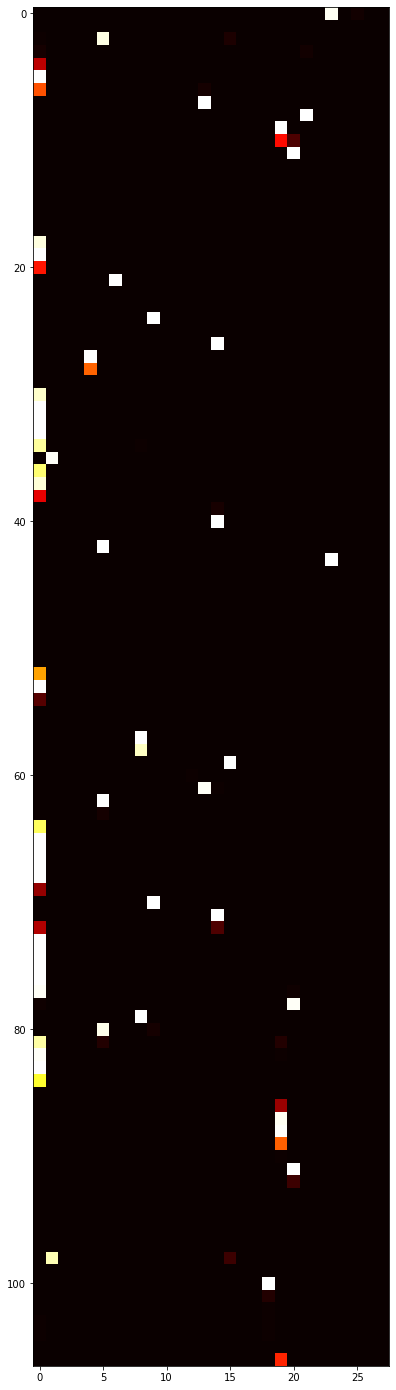

In [81]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,25))
plt.imshow( logits , cmap = 'hot' , interpolation = 'nearest' )
plt.show()
     

Create a heatmap where darker colours are more probable.

<AxesSubplot:>

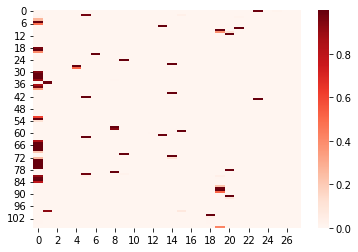

In [82]:
import seaborn as sns

# Load the data for the heatmap
data = logits

# Create the heatmap
sns.heatmap(data, cmap="Reds")

## Exercise 3

In [83]:
"""
Author: Awni Hannun

This is an example CTC decoder written in Python. The code is
intended to be a simple example and is not designed to be
especially efficient.

The algorithm is a prefix beam search for a model trained
with the CTC loss function.

For more details checkout either of these references:
  https://distill.pub/2017/ctc/#inference
  https://arxiv.org/abs/1408.2873

"""

import numpy as np
import math
import collections

NEG_INF = -float("inf")

def make_new_beam():
  fn = lambda : (NEG_INF, NEG_INF)
  return collections.defaultdict(fn)

def logsumexp(*args):
  """
  Stable log sum exp.
  """
  if all(a == NEG_INF for a in args):
      return NEG_INF
  a_max = max(args)
  lsp = math.log(sum(math.exp(a - a_max)
                      for a in args))
  return a_max + lsp

def decode(probs, beam_size=100, blank=0):
  """
  Performs inference for the given output probabilities.

  Arguments:
      probs: The output probabilities (e.g. post-softmax) for each
        time step. Should be an array of shape (time x output dim).
      beam_size (int): Size of the beam to use during inference.
      blank (int): Index of the CTC blank label.

  Returns the output label sequence and the corresponding negative
  log-likelihood estimated by the decoder.
  """
  T, S = probs.shape
  probs = np.log(probs)

  # Elements in the beam are (prefix, (p_blank, p_no_blank))
  # Initialize the beam with the empty sequence, a probability of
  # 1 for ending in blank and zero for ending in non-blank
  # (in log space).
  beam = [(tuple(), (0.0, NEG_INF))]

  for t in range(T): # Loop over time

    # A default dictionary to store the next step candidates.
    next_beam = make_new_beam()

    for s in range(S): # Loop over vocab
      p = probs[t, s]

      # The variables p_b and p_nb are respectively the
      # probabilities for the prefix given that it ends in a
      # blank and does not end in a blank at this time step.
      for prefix, (p_b, p_nb) in beam: # Loop over beam

        # If we propose a blank the prefix doesn't change.
        # Only the probability of ending in blank gets updated.
        if s == blank:
          n_p_b, n_p_nb = next_beam[prefix]
          n_p_b = logsumexp(n_p_b, p_b + p, p_nb + p)
          next_beam[prefix] = (n_p_b, n_p_nb)
          continue

        # Extend the prefix by the new character s and add it to
        # the beam. Only the probability of not ending in blank
        # gets updated.
        end_t = prefix[-1] if prefix else None
        n_prefix = prefix + (s,)
        n_p_b, n_p_nb = next_beam[n_prefix]
        if s != end_t:
          n_p_nb = logsumexp(n_p_nb, p_b + p, p_nb + p)
        else:
          # We don't include the previous probability of not ending
          # in blank (p_nb) if s is repeated at the end. The CTC
          # algorithm merges characters not separated by a blank.
          n_p_nb = logsumexp(n_p_nb, p_b + p)
          
        # *NB* this would be a good place to include an LM score.
        next_beam[n_prefix] = (n_p_b, n_p_nb)

        # If s is repeated at the end we also update the unchanged
        # prefix. This is the merging case.
        if s == end_t:
          n_p_b, n_p_nb = next_beam[prefix]
          n_p_nb = logsumexp(n_p_nb, p_nb + p)
          next_beam[prefix] = (n_p_b, n_p_nb)

    # Sort and trim the beam before moving on to the
    # next time-step.
    beam = sorted(next_beam.items(),
            key=lambda x : logsumexp(*x[1]),
            reverse=True)
    beam = beam[:beam_size]

  best = beam[0]
  return best[0], -logsumexp(*best[1])

In [87]:
seq, logsum = decode(logits, 3, 0)

TypeError: 'numpy.float64' object is not callable

In [88]:
ctc = []
f = open('output.json')
data = json.load(f)
     


In [89]:
for i in seq:
    ctc.append(data["alphabet"][i])

In [90]:
print("".join(ctc))

wemustsisfindanewostholmeinthestsarrs
